Lab 12: DCGAN on CIFAR-10 via KaggleHub

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import kagglehub
import os

 Device setup

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


Download CIFAR-10 Dataset from KaggleHub

In [ ]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize(64),             # For DCGAN input
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

train_dataset = datasets.CIFAR10(root='~/.keras/datasets', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)

print("✅ CIFAR-10 PyTorch DataLoader ready.")
print("Number of training samples:", len(train_dataset))


100%|██████████| 170M/170M [00:04<00:00, 42.2MB/s]


✅ CIFAR-10 PyTorch DataLoader ready.
Number of training samples: 50000


Define Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

Define Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img)

Initialize models, loss, and optimizers

In [ ]:
latent_dim = 100
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

Training Loop

In [ ]:
epochs = 50
fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device)
G_losses, D_losses = [], []

for epoch in range(epochs):
    for imgs, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        real_imgs = imgs.to(device)
        batch_size = real_imgs.size(0)

        # Real and Fake labels
        real_labels = torch.ones(batch_size, 1, 1, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, 1, 1, device=device)

        # --- Train Discriminator ---
        z = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_imgs = generator(z)

        real_loss = criterion(discriminator(real_imgs), real_labels)
        fake_loss = criterion(discriminator(fake_imgs.detach()), fake_labels)
        D_loss = real_loss + fake_loss

        optimizer_D.zero_grad()
        D_loss.backward()
        optimizer_D.step()

        # --- Train Generator ---
        G_loss = criterion(discriminator(fake_imgs), real_labels)
        optimizer_G.zero_grad()
        G_loss.backward()
        optimizer_G.step()

    G_losses.append(G_loss.item())
    D_losses.append(D_loss.item())

    print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {D_loss.item():.4f} | G Loss: {G_loss.item():.4f}")

    # Save generated images every 10 epochs
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            fake = generator(fixed_noise).detach().cpu()
        utils.save_image(fake, f"generated_epoch_{epoch+1}.png", normalize=True, nrow=8)

Epoch 1/50: 100%|██████████| 391/391 [00:56<00:00,  6.92it/s]


Epoch [1/50] | D Loss: 0.3317 | G Loss: 5.2526


Epoch 2/50: 100%|██████████| 391/391 [00:59<00:00,  6.61it/s]


Epoch [2/50] | D Loss: 0.6499 | G Loss: 3.2739


Epoch 3/50: 100%|██████████| 391/391 [01:02<00:00,  6.29it/s]


Epoch [3/50] | D Loss: 1.7764 | G Loss: 5.9727


Epoch 4/50: 100%|██████████| 391/391 [01:01<00:00,  6.36it/s]


Epoch [4/50] | D Loss: 0.1891 | G Loss: 5.9591


Epoch 5/50: 100%|██████████| 391/391 [01:01<00:00,  6.36it/s]


Epoch [5/50] | D Loss: 0.5739 | G Loss: 7.0114


Epoch 6/50: 100%|██████████| 391/391 [01:01<00:00,  6.34it/s]


Epoch [6/50] | D Loss: 0.0195 | G Loss: 5.3233


Epoch 7/50: 100%|██████████| 391/391 [01:01<00:00,  6.32it/s]


Epoch [7/50] | D Loss: 0.0982 | G Loss: 4.1455


Epoch 8/50: 100%|██████████| 391/391 [01:01<00:00,  6.33it/s]


Epoch [8/50] | D Loss: 0.0583 | G Loss: 4.2311


Epoch 9/50: 100%|██████████| 391/391 [01:01<00:00,  6.35it/s]


Epoch [9/50] | D Loss: 0.4103 | G Loss: 4.4837


Epoch 10/50: 100%|██████████| 391/391 [01:01<00:00,  6.34it/s]


Epoch [10/50] | D Loss: 0.3229 | G Loss: 3.6671


Epoch 11/50: 100%|██████████| 391/391 [01:01<00:00,  6.34it/s]


Epoch [11/50] | D Loss: 0.0601 | G Loss: 4.5126


Epoch 12/50: 100%|██████████| 391/391 [01:01<00:00,  6.33it/s]


Epoch [12/50] | D Loss: 0.3105 | G Loss: 2.8844


Epoch 13/50: 100%|██████████| 391/391 [01:01<00:00,  6.33it/s]


Epoch [13/50] | D Loss: 0.6866 | G Loss: 0.6030


Epoch 14/50: 100%|██████████| 391/391 [01:01<00:00,  6.33it/s]


Epoch [14/50] | D Loss: 0.5665 | G Loss: 2.1178


Epoch 15/50: 100%|██████████| 391/391 [01:01<00:00,  6.34it/s]


Epoch [15/50] | D Loss: 0.0081 | G Loss: 6.2439


Epoch 16/50: 100%|██████████| 391/391 [01:01<00:00,  6.33it/s]


Epoch [16/50] | D Loss: 0.1634 | G Loss: 3.9746


Epoch 17/50: 100%|██████████| 391/391 [01:01<00:00,  6.34it/s]


Epoch [17/50] | D Loss: 1.0819 | G Loss: 1.1342


Epoch 18/50: 100%|██████████| 391/391 [01:01<00:00,  6.34it/s]


Epoch [18/50] | D Loss: 0.0707 | G Loss: 5.1831


Epoch 19/50: 100%|██████████| 391/391 [01:01<00:00,  6.32it/s]


Epoch [19/50] | D Loss: 0.0091 | G Loss: 10.3721


Epoch 20/50: 100%|██████████| 391/391 [01:01<00:00,  6.33it/s]


Epoch [20/50] | D Loss: 0.1215 | G Loss: 3.9262


Epoch 21/50: 100%|██████████| 391/391 [01:01<00:00,  6.35it/s]


Epoch [21/50] | D Loss: 0.1854 | G Loss: 3.4378


Epoch 22/50: 100%|██████████| 391/391 [01:00<00:00,  6.45it/s]


Epoch [22/50] | D Loss: 0.0475 | G Loss: 4.6454


Epoch 23/50: 100%|██████████| 391/391 [01:00<00:00,  6.48it/s]


Epoch [23/50] | D Loss: 0.0428 | G Loss: 4.1088


Epoch 24/50: 100%|██████████| 391/391 [01:00<00:00,  6.48it/s]


Epoch [24/50] | D Loss: 0.6810 | G Loss: 3.2551


Epoch 25/50: 100%|██████████| 391/391 [01:00<00:00,  6.48it/s]


Epoch [25/50] | D Loss: 0.2488 | G Loss: 2.8305


Epoch 26/50: 100%|██████████| 391/391 [01:00<00:00,  6.48it/s]


Epoch [26/50] | D Loss: 0.0913 | G Loss: 3.9119


Epoch 27/50: 100%|██████████| 391/391 [01:00<00:00,  6.49it/s]


Epoch [27/50] | D Loss: 0.0072 | G Loss: 8.7125


Epoch 28/50: 100%|██████████| 391/391 [01:00<00:00,  6.50it/s]


Epoch [28/50] | D Loss: 0.0501 | G Loss: 4.3679


Epoch 29/50: 100%|██████████| 391/391 [01:00<00:00,  6.50it/s]


Epoch [29/50] | D Loss: 0.2615 | G Loss: 4.3002


Epoch 30/50: 100%|██████████| 391/391 [01:00<00:00,  6.49it/s]


Epoch [30/50] | D Loss: 0.2848 | G Loss: 4.0473


Epoch 31/50: 100%|██████████| 391/391 [01:00<00:00,  6.48it/s]


Epoch [31/50] | D Loss: 0.3480 | G Loss: 3.1064


Epoch 32/50: 100%|██████████| 391/391 [01:00<00:00,  6.50it/s]


Epoch [32/50] | D Loss: 0.3993 | G Loss: 3.5913


Epoch 33/50: 100%|██████████| 391/391 [01:00<00:00,  6.49it/s]


Epoch [33/50] | D Loss: 0.6913 | G Loss: 2.2605


Epoch 34/50: 100%|██████████| 391/391 [01:00<00:00,  6.49it/s]


Epoch [34/50] | D Loss: 0.2731 | G Loss: 3.1639


Epoch 35/50: 100%|██████████| 391/391 [01:00<00:00,  6.49it/s]


Epoch [35/50] | D Loss: 0.0022 | G Loss: 8.4192


Epoch 36/50: 100%|██████████| 391/391 [01:00<00:00,  6.50it/s]


Epoch [36/50] | D Loss: 0.1767 | G Loss: 4.2216


Epoch 37/50: 100%|██████████| 391/391 [01:00<00:00,  6.50it/s]


Epoch [37/50] | D Loss: 0.8859 | G Loss: 3.3729


Epoch 38/50: 100%|██████████| 391/391 [01:00<00:00,  6.49it/s]


Epoch [38/50] | D Loss: 0.0355 | G Loss: 5.5523


Epoch 39/50: 100%|██████████| 391/391 [01:00<00:00,  6.49it/s]


Epoch [39/50] | D Loss: 0.2282 | G Loss: 3.0465


Epoch 40/50: 100%|██████████| 391/391 [01:00<00:00,  6.50it/s]


Epoch [40/50] | D Loss: 0.6156 | G Loss: 3.3211


Epoch 41/50: 100%|██████████| 391/391 [01:00<00:00,  6.48it/s]


Epoch [41/50] | D Loss: 0.0374 | G Loss: 4.4274


Epoch 42/50: 100%|██████████| 391/391 [01:00<00:00,  6.49it/s]


Epoch [42/50] | D Loss: 0.6363 | G Loss: 2.2881


Epoch 43/50: 100%|██████████| 391/391 [01:00<00:00,  6.50it/s]


Epoch [43/50] | D Loss: 0.1242 | G Loss: 5.1184


Epoch 44/50: 100%|██████████| 391/391 [01:00<00:00,  6.49it/s]


Epoch [44/50] | D Loss: 0.0016 | G Loss: 9.0231


Epoch 45/50: 100%|██████████| 391/391 [01:00<00:00,  6.49it/s]


Epoch [45/50] | D Loss: 0.0025 | G Loss: 7.8578


Epoch 46/50: 100%|██████████| 391/391 [01:00<00:00,  6.49it/s]


Epoch [46/50] | D Loss: 0.3838 | G Loss: 4.2818


Epoch 47/50: 100%|██████████| 391/391 [01:01<00:00,  6.34it/s]


Epoch [47/50] | D Loss: 0.1003 | G Loss: 3.6491


Epoch 48/50: 100%|██████████| 391/391 [01:01<00:00,  6.37it/s]


Epoch [48/50] | D Loss: 0.0333 | G Loss: 5.6246


Epoch 49/50: 100%|██████████| 391/391 [01:00<00:00,  6.44it/s]


Epoch [49/50] | D Loss: 0.0240 | G Loss: 5.2035


Epoch 50/50: 100%|██████████| 391/391 [01:00<00:00,  6.47it/s]


Epoch [50/50] | D Loss: 0.0264 | G Loss: 5.6373


Visualizations

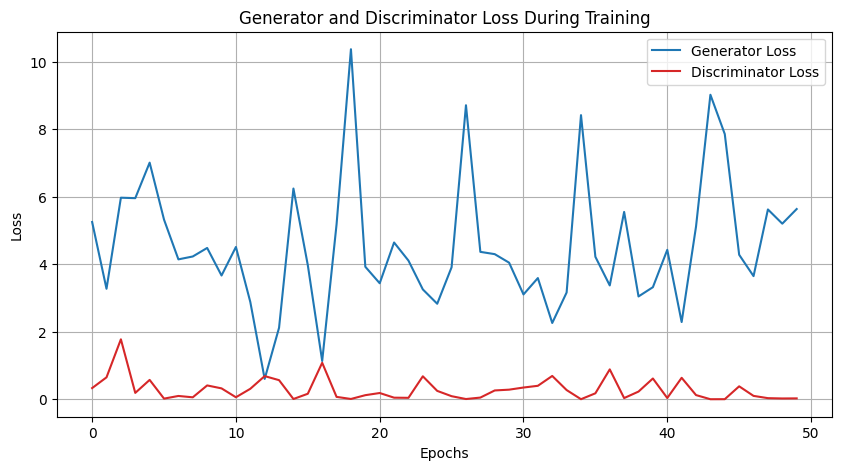

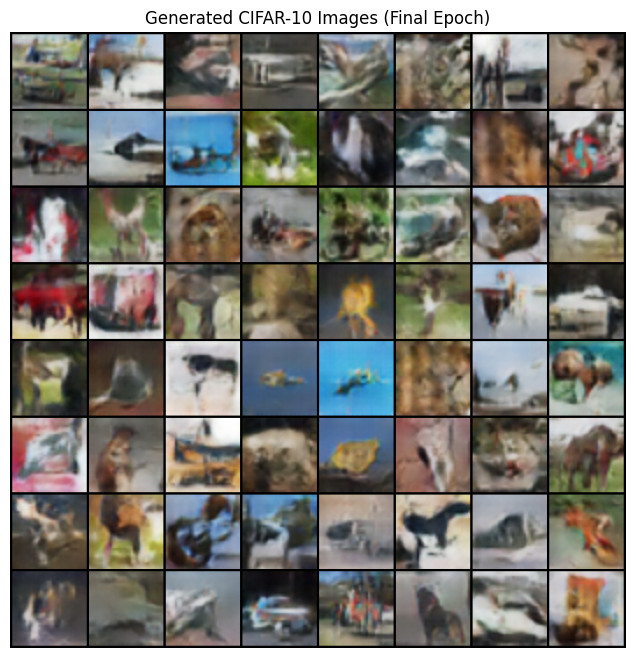

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="Generator Loss", color='tab:blue')
plt.plot(D_losses, label="Discriminator Loss", color='tab:red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Display generated images
with torch.no_grad():
    fake = generator(fixed_noise).detach().cpu()
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Generated CIFAR-10 Images (Final Epoch)")
plt.imshow(np.transpose(utils.make_grid(fake, padding=2, normalize=True), (1,2,0)))
plt.show()
